In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [2]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      1.3.0
aiohttp                      3.8.3
aiosignal                    1.2.0
anyio                        3.5.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asttokens                    2.0.5
astunparse                   1.6.3
async-timeout                4.0.2
attrs                        21.4.0
Babel                        2.9.1
backcall                     0.2.0
beautifulsoup4               4.11.1
bleach                       4.1.0
blis                         0.7.9
Bottleneck                   1.3.5
brotlipy                     0.7.0
cachetools                   5.2.0
catalogue                    2.0.8
certifi                      2022.9.24
cffi                         1.15.1
charset-normalizer           2.0.4
click                        8.1.3
colorama                     0.4.5
colour                       0.1.5
confection                   0.0.3
cry

In [50]:
import tensorflow as tf
import os as os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [7]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
tf.config.list_physical_devices('GPU')

[]

In [9]:
gpus = tf.config.experimental.list_physical_devices('CPU')

In [10]:
len(gpus)

1

In [11]:
gpus_local = tf.config.experimental.list_logical_devices('GPU')

In [12]:
len(gpus_local)

0

In [13]:
data_dir = 'data'

In [14]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [15]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [16]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 442 files belonging to 2 classes.


In [17]:
data_iterator = data.as_numpy_iterator()

In [18]:
batch = data_iterator.next()

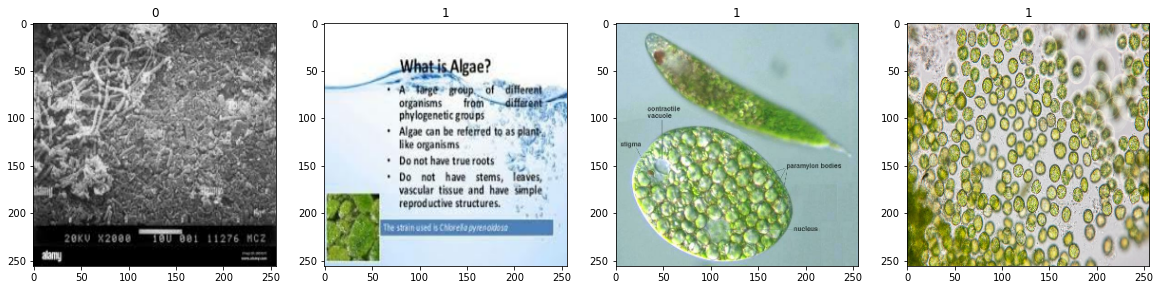

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [20]:
data = data.map(lambda x,y: (x/255, y))

In [21]:
data.as_numpy_iterator().next()

(array([[[[0.6509804 , 0.8156863 , 0.80784315],
          [0.6509804 , 0.8156863 , 0.80784315],
          [0.6509804 , 0.8156863 , 0.80784315],
          ...,
          [0.7411765 , 0.8784314 , 0.89411765],
          [0.7411765 , 0.8784314 , 0.89411765],
          [0.7411765 , 0.8784314 , 0.89411765]],
 
         [[0.6509804 , 0.8156863 , 0.80784315],
          [0.6509804 , 0.8156863 , 0.80784315],
          [0.6509804 , 0.8156863 , 0.80784315],
          ...,
          [0.7411765 , 0.8784314 , 0.89411765],
          [0.7411765 , 0.8784314 , 0.89411765],
          [0.7411765 , 0.8784314 , 0.89411765]],
 
         [[0.6509804 , 0.8156863 , 0.80784315],
          [0.6509804 , 0.8156863 , 0.80784315],
          [0.6509804 , 0.8156863 , 0.80784315],
          ...,
          [0.7411765 , 0.8784314 , 0.89411765],
          [0.7411765 , 0.8784314 , 0.89411765],
          [0.7411765 , 0.8784314 , 0.89411765]],
 
         ...,
 
         [[0.7019608 , 0.8039216 , 0.7921569 ],
          [0.70196

In [22]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [23]:
val_size

2

In [24]:
train_size

9

In [25]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [26]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [27]:
model = Sequential()

In [28]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [31]:
logdir='logs'

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [33]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
9/9 [==============================] - 9s 808ms/step - loss: 0.9290 - accuracy: 0.5174 - val_loss: 0.6721 - val_accuracy: 0.6094
Epoch 2/20
9/9 [==============================] - 8s 830ms/step - loss: 0.6580 - accuracy: 0.6354 - val_loss: 0.6554 - val_accuracy: 0.5938
Epoch 3/20
9/9 [==============================] - 8s 781ms/step - loss: 0.6354 - accuracy: 0.6250 - val_loss: 0.6605 - val_accuracy: 0.5469
Epoch 4/20
9/9 [==============================] - 8s 857ms/step - loss: 0.5990 - accuracy: 0.6285 - val_loss: 0.5837 - val_accuracy: 0.6094
Epoch 5/20
9/9 [==============================] - 8s 829ms/step - loss: 0.5928 - accuracy: 0.6806 - val_loss: 0.6002 - val_accuracy: 0.6406
Epoch 6/20
9/9 [==============================] - 8s 797ms/step - loss: 0.5549 - accuracy: 0.6840 - val_loss: 0.5062 - val_accuracy: 0.7656
Epoch 7/20
9/9 [==============================] - 8s 829ms/step - loss: 0.5432 - accuracy: 0.6771 - val_loss: 0.4536 - val_accuracy: 0.7969
Epoch 8/20
9/9 [====

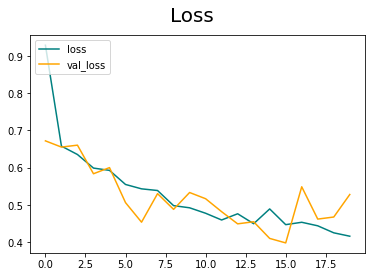

In [34]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

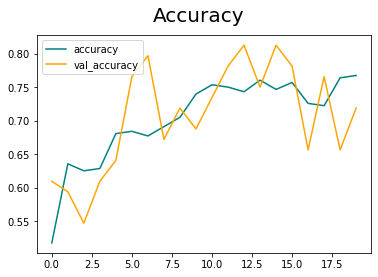

In [35]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [36]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [37]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 316ms/step


In [38]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.33333334, shape=(), dtype=float32) tf.Tensor(0.6875, shape=(), dtype=float32)


In [43]:
predictions = model.predict(X)

1/1 [==============================] - 0s 162ms/step


In [49]:
confusion_matrix(y,predictions)

ValueError: Classification metrics can't handle a mix of binary and continuous targets